**Importing all the libraries and reading the data**

In [3]:
# importing all the required libraries
import numpy as np
import pandas as pd
import csv
import random
import math
import time
import matplotlib

# importing test-train split
from sklearn.model_selection import train_test_split

# importing measuring attributes
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

# reading and loading the data
data_url = "https://web.stanford.edu/~hastie/ElemStatLearn//datasets/spam.data"
train_data = pd.read_csv(data_url,header=None,delim_whitespace=True)
train_data = np.array(train_data)

**Classes for Decision Node and Tree Node**

In [4]:
# Decision node
# Contains Index of split, threshold, information gain, left sub tree, right sub tree
class decisionNode():
    def __init__ (self, splitObj, leftNode = None, rightNode = None):
        self.fIndex = splitObj.get("fIndex")
        self.threshold = splitObj.get("threshold")
        self.informationGain = splitObj.get("informationGain")
        self.left = leftNode
        self.right = rightNode
        self.isLeaf = False

# leaf Node
# Contains only value as it is the leaf
class leafNode():
    def __init__ (self,value = None):
        self.value = value
        self.isLeaf = True

**Class for Decision Tree**

In [5]:
# Implement your decision tree below
# Decision tree
class DecisionTree():
      
    def __init__(self):
        self.reqFeatures = 0

    # setting the depth essentially(improvement)
    shallowDepth = None
    # tree
    tree = {}

    # Build tree function
    def buildTree(self, training_set, curDepth = 0):
        
        # Abstract the features of the training set
        features = training_set[:,:-1]
        # print(features,len(features))
        # return
        # Abrstract the results of the features
        result = training_set[:,-1]

        # n(number of features)
        numberOfFeatures = len(features[0])
        # print(curDepth,self.shallowDepth)
        # Adding the check to stop the overfitting of the tree
        if curDepth <= self.shallowDepth:
            # print("loading")
            # get the best split
            bestSplit = self.getBestSplit(training_set,numberOfFeatures)

            # If information Gain of the obtained best split is positive,
            # build the left sub tree, right sub tree and return the decision node
            # decision node contains, index of classification, threshold value, left tree, right tree, information gain
            if bestSplit.get("informationGain"):
                # print(bestSplit["informationGain"])
                if bestSplit["informationGain"] > 0:
                    leftSubtree = self.buildTree(bestSplit["leftData"],curDepth+1)
                    rightSubtree = self.buildTree(bestSplit["rightData"],curDepth+1)
                    return decisionNode(bestSplit,leftSubtree,rightSubtree)
                    
        # We keep a leaf in the tree, Either if depth is reached to max depth or else when the
        # information gain is 0, then it can be classified easily(only one type of class is present)
        
        # Returns the key which is repeated max times in the list
        resultList = list(result)
        return leafNode(max(resultList, key=resultList.count))

    # utility function to store the attributes and return a python dictionary
    def fitInsplit(self,split={},index=None,threshold=None,gain=None):
        split["fIndex"] = index
        split["threshold"] = threshold
        split["informationGain"] = gain
        return split

    # get random feature indices from all the indices
    def generateRandom(self,total,required):
        values = list(range(total))
        return random.sample(population=values,k=required)

    # get the possible thresholds
    def getThreshold(self,mini,maxi):
        diff = maxi - mini
        samples = 20
        thresholds = []
        increment = round(diff/samples)
        temp = mini
        for i in range(samples):
            thresholds.append(temp)
            temp += increment
        return thresholds
        
    # function to get best split
    def getBestSplit(self, training_set, numberOfFeatures):
        
        # make an empty dictionary
        bestSplit = {}
        # mark initial gain is negative infinity
        infoGain = -float("Inf")
        
        randomList = self.generateRandom(numberOfFeatures,self.reqFeatures)

        # Iterate over the index over the number of features
        for index in randomList:

            value = training_set[:,index]
            possibleThresholds = np.unique(value)

            max_value = min_value = training_set[0][index]
            
            for i in range(len(training_set)):
                max_value = max(max_value,training_set[i][index])
                min_value = min(min_value,training_set[i][index])
                
            possibleThresholds = self.getThreshold(min_value,max_value)
            
            # Iterate over the possible thresholds
            for threshold in possibleThresholds:
            
                # split the data into two, left and right
                leftData = []
                rightData = []
                for row in training_set:
                    if row[index] <= threshold:
                        leftData.append(row)
                    else:
                        rightData.append(row)
                    # (rightData,leftData)[row[index] <= threshold].append(row)
                leftData = np.array(leftData)
                rightData = np.array(rightData)

                # Compute the information Gain and update the best splits
                if len(leftData) and len(rightData):
                    y = training_set[:,-1]
                    leftY = leftData[:,-1]
                    rightY = rightData[:,-1]

                    # Computing the information gain
                    # presentGain = self.getGiniInformationGain(y,leftY,rightY)
                    presentGain = self.getGiniInformationGain(y,leftY,rightY)

                    # print(presentGain,infoGain)
                    if presentGain >= infoGain:
                        bestSplit = self.fitInsplit(bestSplit,index,threshold,infoGain)
                        bestSplit["leftData"] = leftData
                        bestSplit["rightData"] = rightData
                        infoGain = presentGain

        return bestSplit

    # Gini Index
    def getGiniIndex(self, y):
        # Initialize gini index with 1
        gini = 1
        
        # calculate the probability of each class present and 
        # substract the square of it from gini 
        # It essentially gives the value between 0 and 0.5
        if 0 in y:
            prob = np.count_nonzero(y == 0) /len(y)
            gini -= prob ** 2
        if 1 in y:
            prob = np.count_nonzero(y == 1) /len(y)
            gini -= prob ** 2

        # return gini index
        return gini
    
    # Calculating the information gain from Gini Index
    def getGiniInformationGain(self, parent, lChild, rChild):
        # mark the length of the parent
        lenParent = len(parent)
        # calculate the gini index of parent
        gain = self.getGiniIndex(parent)
        # substract the weighted gini index from the gain obtained from parent
        gain -= (len(lChild)* self.getGiniIndex(lChild))/lenParent
        gain -= (len(rChild)* self.getGiniIndex(rChild))/lenParent
        
        # return the information gain
        return gain

    # implement this function
    # Function which builds tree
    def learn(self, training_set,reqFeatures=None):
        # converting it to numpy array for further manipulation
        training_data = np.array(training_set)
        # noting the shape of data
        size,depth = training_data.shape
        # assigning the max depth
        self.shallowDepth = 6
        # Build the tree and store it the tree
        self.reqFeatures = reqFeatures if reqFeatures is not None else round(math.sqrt(len(training_set[0])-1))
        self.tree = self.buildTree(training_data)
        
    # implement this function
    # Function which classifies based on the features and the existing tree
    def classify(self,test_instance,dtree=None):
    
        # if it is a valid decision node
        if dtree:
            # if value is a truthy value, return the value
            # Decision node has the value attribute as falsy and leaf node has truthy value
            if dtree.isLeaf:
                # return leaf value
                return dtree.value
            
            # collect the value of test instance at the row, according to the data present in decision node
            value = test_instance[dtree.fIndex]

            # based on the value, return the answer from left and right sub tree
            return self.classify(test_instance,dtree.left) if value <= dtree.threshold \
                else self.classify(test_instance,dtree.right)
        
        # Just a tweak, not to write other function and not to change the definition of
        # classify method given in the resources
        else:
            dtree = self.tree
            return self.classify(test_instance,dtree)
        


**Class for Random Forest**

In [6]:
# random forest class
class randomForest():
  # constructor with default number of trees set to 10
  def __init__(self,numtrees=10):
    self.numtrees = numtrees
    self.trees = []
    self.testingdata = []
    self.oobtrees = []

  # fit method to train the model with the given data
  def fit(self,X,y,reqFeatures=None):
    num_built = 0
    res = []
    # create a new tree every time with some random features
    while num_built < self.numtrees:
      newDt = DecisionTree()
      X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)
      self.testingdata = ([X_test,y_test])
      temp = np.concatenate((X_train, y_train[:,None]),axis=1)
      # training method on decision tree
      newDt.learn(temp,reqFeatures)
      self.trees.append(newDt)
      num_built += 1
  
  # fit and get method to train the model with bootstrapped data
  def fit_and_get_OOB(self,X_bootstrap,y_bootstrap,X_oob,y_oob,reqFeatures=None):
    num_built = 0
    res = []
    while num_built < self.numtrees:
      newDt = DecisionTree()
      y_bootstrap = np.array(y_bootstrap)
      y_bootstrap = y_bootstrap.reshape(len(y_bootstrap),)
      temp = np.concatenate((X_bootstrap, y_bootstrap[:,None]),axis=1)
      newDt.learn(temp,reqFeatures)
      self.oobtrees.append(newDt)
      num_built += 1
    res = self.oobpredict(X_oob,y_oob)
    return res

  # predict helper
  def bagging_predict(self,trees, row):
    predictions = [tree.classify(row) for tree in trees]
    return max(set(predictions), key=predictions.count)

  # predict method
  def predict(self):
    predictions = [self.bagging_predict(self.trees, row) for row in self.testingdata[0]]
    return [accuracy_score(predictions,self.testingdata[1]),recall_score(self.testingdata[1],predictions)]

  # prediction on test method
  def predicttest(self,X_test,y_test):
    predictions = [self.bagging_predict(self.oobtrees, row) for row in X_test]
    return accuracy_score(predictions,y_test)

  # predicting oob accuracy
  def oobpredict(self,X_oob,y_oob):
    predictions = [self.bagging_predict(self.oobtrees, row) for row in X_oob]
    return accuracy_score(predictions,y_oob)


**4a. Measuring accuracy on Random Forest**

In [7]:
# 4a

# splitting the data into X and y
X = train_data[:,:-1]
y = train_data[:,-1]
# measuring the start time
start_time = time.time()
# creating and evaluating the model
model = randomForest()
model.fit(X,y)
res = model.predict()
print("Accuracy score with own random forest : ",res[0])
# measuring the time taken
print("--- Time taken --- %s seconds ---" % (time.time() - start_time))

Accuracy score with own random forest :  0.9029688631426502
--- Time taken --- 37.53448295593262 seconds ---


**4a. In built Random Forest**

In [8]:
# 4a

# importing Random Forest Classifier and creating the model
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10,max_features='sqrt',max_depth=6)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)

# measuring the time taken and evaluting the time taken
start_time = time.time()
model.fit(X_train,y_train)
print("Accuracy score with inbuilt random forest : ",model.score(X_test,y_test))
print("--- Time taken --- %s seconds ---" % (time.time() - start_time))

Accuracy score with inbuilt random forest :  0.9312092686459088
--- Time taken --- 0.052702903747558594 seconds ---


**4b. Exploring Sensitivity**

In [9]:
# 4b

# exploring sensitivity with below number of features
features = [5,10,15,20]
accuracy = []
time_taken = []
sensitivity = []

# created a model of Random Forest
model = randomForest()
# loop over number of features
for num in features:
  # measure the start time
  start_time = time.time()
  # train the forest
  model.fit(X,y,num)
  # get accuracy and Sensitivity from the model
  temp = model.predict()

  # Record the observations
  accuracy.append(temp[0])
  sensitivity.append(temp[1])
  time_taken.append((time.time() - start_time))
  print("Completed forest with ",num," features")

for i in range(len(features)):
  print("Number of features : ",features[i], ", Accuracy : ",accuracy[i], ", Time taken : ",time_taken[i], "s, Recall Score : ",sensitivity[i])

Completed forest with  5  features
Completed forest with  10  features
Completed forest with  15  features
Completed forest with  20  features
Number of features :  5 , Accuracy :  0.8805213613323678 , Time taken :  21.47656774520874 s, Recall Score :  0.7213114754098361
Number of features :  10 , Accuracy :  0.9217958001448225 , Time taken :  50.81852197647095 s, Recall Score :  0.8257575757575758
Number of features :  15 , Accuracy :  0.9268645908761767 , Time taken :  73.12491822242737 s, Recall Score :  0.8495726495726496
Number of features :  20 , Accuracy :  0.9246922519913107 , Time taken :  90.66081619262695 s, Recall Score :  0.8553113553113553


**4b. Visualising Data**

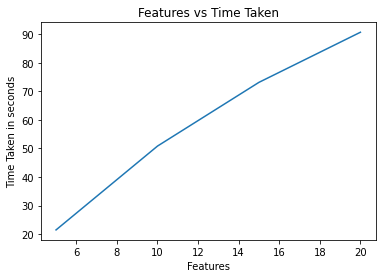

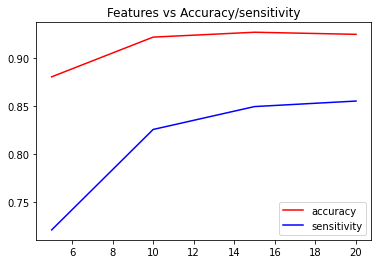

In [28]:
# 4b
# printing down the graph for better visualisation
import matplotlib.pyplot as plt
plt.plot(features,time_taken)
plt.title('Features vs Time Taken')
plt.xlabel('Features')
plt.ylabel('Time Taken in seconds')
plt.show()
plt.plot(features,accuracy,'r-',label="accuracy")
plt.title('Features vs Accuracy/sensitivity')
plt.plot(features,sensitivity,'b-',label="sensitivity")
plt.ylim = [0.6,1.4]
plt.legend(loc="best")
plt.show()

**4c. Observing OOB and Test Error**

Number of Features :  6
OOB error :  0.09924550203134064
Test error :  0.07458363504706733
Number of Features :  7
OOB error :  0.09994222992489887
Test error :  0.07965242577842147
Number of Features :  8
OOB error :  0.10136336692353287
Test error :  0.07965242577842147
Number of Features :  10
OOB error :  0.11601884570082455
Test error :  0.09341057204923964
Number of Features :  12
OOB error :  0.09723040659988214
Test error :  0.07965242577842147


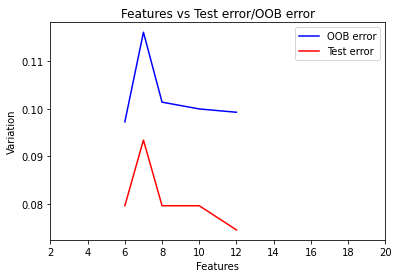

In [27]:
# 4c

# class for Out of bag error calculations
class oobError:
  def __init__ (self,training_set):
    self.ooberror = []
    self.test_error = []
    self.numFeatures = []
    self.defFeatures = []
    self.forests = []
    self.oobsamples = []
    self.build(training_set)
    self.evaluate()

  # get sample method which gives bootstrapped data
  def getsample(self,X_train,y_train):
    bootstrap_indices = list(np.random.choice(range(len(X_train)), len(X_train), replace = True))
    oob_indices = [i for i in range(len(X_train)) if i not in bootstrap_indices]
    X_bootstrap = X_train.iloc[bootstrap_indices].values
    y_bootstrap = y_train.iloc[bootstrap_indices]
    X_oob = X_train.iloc[oob_indices].values
    y_oob = y_train.iloc[oob_indices]
    return [X_bootstrap, y_bootstrap, X_oob, y_oob]

  # build method to set right the forests, number of features and bootstrapped samples
  def build(self,training_set):
    self.defFeatures = len(training_set[0])
    X_train = train_data[:,:-1]
    y_train = train_data[:,-1]
    for num in range(5,10):
      features = round(self.defFeatures/num)
      self.numFeatures.append(features)
      forest = randomForest()
      self.forests.append(forest)
      sample = self.getsample(pd.DataFrame(X_train),pd.DataFrame(y_train))
      self.oobsamples.append(sample)

  # evaluate method trains the model with bootstrapped data, and gets both the OOB error prediction and test error prediction 
  def evaluate(self):
    for i in reversed(range(5)):
      print("Number of Features : ",self.numFeatures[i])
      res = 1-self.forests[i].fit_and_get_OOB(self.oobsamples[i][0],self.oobsamples[i][1],self.oobsamples[i][2],self.oobsamples[i][3])
      self.ooberror.append(res)
      print("OOB error : ", res)
      res = 1-self.forests[i].predicttest(X_test,y_test)
      print("Test error : ", res)
      self.test_error.append(res)

    # plotting the graph for better visualisation
    plt.plot(self.numFeatures,self.ooberror,color='b',label="OOB error")
    plt.xlabel("Features")
    plt.ylabel("Variation")
    # plt.show()

    plt.plot(self.numFeatures,self.test_error,color='r',label="Test error")
    plt.title("Features vs Test error/OOB error")
    plt.xlim([2,20])
    plt.ylim = [0.00,0.2]
    plt.legend()
    plt.show()
model = oobError(train_data)
